<a href="https://colab.research.google.com/github/Gabriel-Sanchez/Lab_Sonic/blob/main/Copy_of_SONIC_FIRST_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entorno de trabajo

In [ ]:
! pip install gym-retro
! pip install imutils
! pip install opencv-python

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import retro

## PRIMER ALGORITMO DE APRENDIZAJE SUPERVISADO
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split

In [ ]:
! python -m retro.import /content/drive/MyDrive/IA_LAB1/roms

Importing SonicTheHedgehog-Genesis
Imported 1 games


Creando el dataset de SONIC usando un codigo de playback y el archivo bk2, que grabamos en nuestra maquina.

Como el algoritmo de Support Vector Machine, no soporta vectores en el target transformaos el arreglo de target a un formato que parezca numero binario. 

Luego lo transformaremos de vuelta a vector



# Creando dataset basico

In [ ]:
def convert_from_array_to_decimal(keys):
  ints = keys
  string_ints = [str(int) for int in ints]
  string = "".join(string_ints)
  return int(string, 2)

def convert_from_decimal_to_array(number):
  string_ints = str(np.base_repr(number)).rjust(12, '0')
  return list(map(int, string_ints))
  
# Hacen lista de los archivos que generaro
movie = retro.Movie('/content/drive/MyDrive/IA_LAB1/Sonic.bk2')
# Los cargan
movie.step()

env = retro.make(
    game=movie.get_game(),
    state=None,
    # bk2s can contain any button presses, so allow everything
    use_restricted_actions=retro.Actions.ALL,
    players=movie.players,
)
env.initial_state = movie.get_state()
world = np.asarray(env.reset()).reshape(-1)
target = np.array([0])
while movie.step():
    img = np.asarray(env.render(mode='rgb_array')).reshape(-1)
    world = np.vstack((world, img))
    keys = []
    for p in range(movie.players):
        for i in range(env.num_buttons):
            keys.append(movie.get_key(i, p))
    keys = [int(elem) for elem in keys]
    number = convert_from_array_to_decimal(keys)
    target = np.append(target, number)
    ob, rew, done, info = env.step(keys)
env.close()

In [ ]:
world

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [ 32,   0, 168, ...,  96,  32,   0],
       [ 32,   0, 168, ...,  96,  32,   0],
       [ 32,   0, 168, ...,  96,  32,   0]], dtype=uint8)

In [ ]:
target[100]



16



# Entrenando el modelo SVM

En esta seccion se procede a entrenar el modelo. Si no desea esperar las dos horas de entrear el modelo, puede pasar a la seccion donde continuamos con la evaluacion del modelo. El prime algoritmo que revisaremos sera Support Vector Machine SVM

Por ahora solo cambiaremos el valor gama, todo variable que le pasemos a los algoritmos le llamaremos Hiper parametro, en el caso de SVM usaremos Gamma, [Mas detalles](https://towardsdatascience.com/hyperparameter-tuning-for-support-vector-machines-c-and-gamma-parameters-6a5097416167)



In [ ]:
clf = svm.SVC(gamma=0.001)
X_train, X_test, y_train, y_test = train_test_split(world, target, test_size=0.25, shuffle=True)

Aqui inicial entrenamiento

NOTA IMPORTANTE: La complejidad se SVM se calcula O(n_samples^2 * n_features) 

El algoritmo que usamos esta descrito [aqui](https://scikit-learn.org/stable/modules/svm.html)

In [ ]:
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

El modelo, se entro no deberian volver a entrenarlo, pues demora casi 2 horas en estar listo con SVM.  

Asi que procederemos a guardarlo, esto es lo que generalmente hacen los cientificos para probar la fiabilidad de un modelo en diferentes esencarios, lo entrenan y se lo llevan a otro lado. Para este caso lo estoy guardado en una carpeta en mi google drive

In [ ]:
import pickle
filename = '/content/drive/MyDrive/IA_LAB1/finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))


Tambien guardaremos los datos de prueba, pues son importantes para hacer la evaluacion y de verdad no queremos entrenar esto de nuevo

In [ ]:
filename_XTEST = '/content/drive/MyDrive/IA_LAB1/X_TEST.sav'
filename_YTEST = '/content/drive/MyDrive/IA_LAB1/Y_TEST.sav'
filename_XTRAIN = '/content/drive/MyDrive/IA_LAB1/X_TRAIN.sav'
filename_YTRAIN = '/content/drive/MyDrive/IA_LAB1/Y_TRAIN.sav'
pickle.dump(X_test, open(filename_XTEST, 'wb'))
pickle.dump(y_test, open(filename_YTEST, 'wb'))
pickle.dump(X_train, open(filename_XTRAIN, 'wb'))
pickle.dump(Y_train, open(filename_YTRAIN, 'wb'))



# Evaluacion del modelo Support Vector Machine

Para esta seccion usaremos el modelo guardado en el disco. Para evitar que en caso de que se cierre la sesion, debamos reentrenar todo.



In [ ]:
! pip install gym-retro
! pip install imutils
! pip install opencv-python
! python -m retro.import /content/drive/MyDrive/IA_LAB1/roms

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import retro

from sklearn import svm, metrics
from sklearn.model_selection import train_test_split

import pickle
filename = '/content/drive/MyDrive/IA_LAB1/finalized_model.sav'
filename_XTEST = '/content/drive/MyDrive/IA_LAB1/X_TEST.sav'
filename_YTEST = '/content/drive/MyDrive/IA_LAB1/Y_TEST.sav'
loaded_model = pickle.load(open(filename, 'rb'))
xtest = pickle.load(open(filename_XTEST, 'rb'))
ytest = pickle.load(open(filename_YTEST, 'rb'))





Importing SonicTheHedgehog-Genesis
Imported 1 games


In [ ]:
predicted = loaded_model.predict(xtest)

Confusion matrix:
[[  2 111   0   0   0   0]
 [  0 445   0   0   0   0]
 [  0  32   0   0   0   0]
 [  0  29   0   0   0   0]
 [  0 113   0   0   0   0]
 [  0  39   0   0   0   0]]


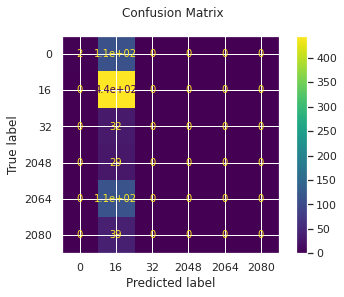

In [ ]:

disp = metrics.plot_confusion_matrix(loaded_model, xtest, ytest)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

Esta matriz de confusion se ve horrible, porque ignoro todo los movimientos siempre decidio saltar en todos los casos. Eso solo puede significar que le falta variedad a la poblacion. Tambien significa que hay una sobrepoblacion de la accion 16. Esto se traduce a que sonic piensa, que lo mejor para resolver los casos de prueba es hacer siempre la accion 16, pero cual es esta accion?

In [ ]:
def convert_from_decimal_to_array(number):
  string_ints = str(np.base_repr(number)).rjust(12, '0')
  return list(map(int, string_ints))
convert_from_decimal_to_array(16)

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

Esto si lo vemos en el control de sega es la accion,

["B", "A", "MODE", "START", "UP", "DOWN", "LEFT", "RIGHT", "C", "Y", "X", "Z"]

Ir a la derecha, ese SONIC ya esta muerto, solo que no le han avisado.

De igual forma, vamos a analizarlo,

In [ ]:
print(f"Classification report for classifier {loaded_model}:\n" f"{metrics.classification_report(ytest, predicted)}\n")

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       1.00      0.02      0.03       113
          16       0.58      1.00      0.73       445
          32       0.00      0.00      0.00        32
        2048       0.00      0.00      0.00        29
        2064       0.00      0.00      0.00       113
        2080       0.00      0.00      0.00        39

    accuracy                           0.58       771
   macro avg       0.26      0.17      0.13       771
weighted avg       0.48      0.58      0.43       771




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Vamos a verlo ahora en accion, para que podamos corroborar lo que les estoy diciendo.

Para eso tenemos que ejecutar el mundo virtul, y desplegarlo en una grafica, luego enviarlo al modelo para ver el resultado, y ese resultado transformarlo en un vector para que mueva a sonic.

In [ ]:
! pip install scikit-image

KeyboardInterrupt: ignored

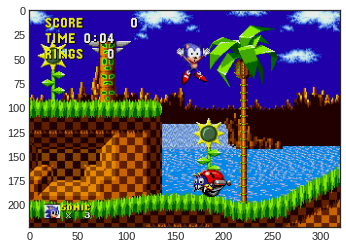

In [ ]:

import retro

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')
 
# Procesamento de imagenes
from skimage.transform import resize
from skimage.color import rgb2gray
from IPython import display

def convert_from_decimal_to_array(number):
  string_ints = str(np.base_repr(number)).rjust(12, '0')
  return list(map(int, string_ints))

done = False
try:
  env = retro.make('SonicTheHedgehog-Genesis', 'GreenHillZone.Act1')
  observation = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))
  while not done:
      world = env.render(mode='rgb_array')
      world_data = np.asarray(world).reshape(-1)
      img.set_data(world)
      display.display(plt.gcf())
      display.clear_output(wait=True)
      predicted = loaded_model.predict([world_data])
      action = convert_from_decimal_to_array(predicted[0])
      ob, rew, done, info = env.step(action)
      #print("Action ", action, "Reward ", rew)
except Exception as e:
  print(e)
  env.close()

Como ven en la imagen no aprendio a saltar, aprendio a avanzar a hacia el frente y esto fue provocado por la falta de diversidad del dataset